In [2]:
import numpy as np
import matplotlib.pyplot  as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from sklearn.model_selection import train_test_split
from keras import metrics
from sklearn.preprocessing import StandardScaler
from google.colab import drive

In [3]:
np.random.RandomState(seed=42)

RandomState(MT19937) at 0x7F4E8D15CBA0

In [4]:
def accuracy_plot(y_test, y_pred):
  plt.scatter(y_test,y_pred,color="r")
  plt.xlabel("True delay")
  plt.xlabel("ML delay")
  plt.plot([-0.06*1e3,0.06*1e3],[-0.06*1e3,0.06*1e3],':')
  plt.xlim([-0.06*1e3,0.06*1e3])
  plt.ylim([-0.06*1e3,0.06*1e3])

In [5]:
def howGoodAmI(y_test, y_pred):
  diff = y_test - y_pred.ravel()
  hist = plt.hist(diff)
  bincentres = (hist[1][:-1]+hist[1][1:])/2.
  weights = hist[0]
  mu = np.average(bincentres,weights=weights)
  sigma = np.average((bincentres-mu)**2, weights=weights)
  return mu, sigma

In [6]:
def error_evolution(h):
  # summarize history for loss
  plt.plot(h.history['mean_squared_error'], label='train')
  plt.plot(h.history['val_mean_squared_error'], label='test')
  plt.title('model mse')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  plt.legend()

In [7]:
def ccf(x):
  half = len(x)//2
  a, b = x[0:half], x[half:]
  a = (a - np.mean(a)) / (np.std(a) * len(a))
  b = (b - np.mean(b)) / (np.std(b))
  return np.correlate(a,b,'same')

In [8]:
# load data
drive.mount('/content/drive')
copypath = '/content/drive/My Drive/data/lightcurve_array_1ms_6e4.npz' # 60 000 lc
# copypath = '/content/drive/My Drive/data/lightcurve_array.npz' # 9999 lc
npz=np.load(copypath)
xdata=npz['lc'][:,:-1] # to make the legth of the two concatenated light curves an even number
ydata=npz['delay']*1e3 # convert to human read units
xdata.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(59999, 9998)

Delay is 49.97


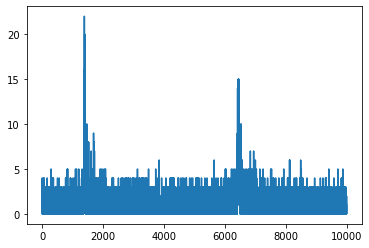

In [9]:
lc0 = xdata[0]
plt.plot(lc0)
print("Delay is {:.2f}".format(ydata[0]))

Delay is 49.97


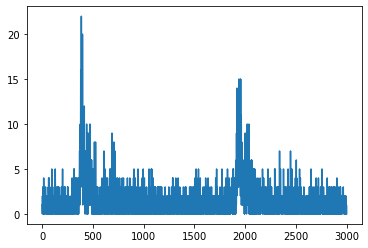

In [10]:
# take just data points around signal
half = xdata.shape[1]//2
xdata = np.concatenate([xdata[:,1000:2500], xdata[:,1000+half:2500+half]], axis=1)
lc0 = xdata[0]
plt.plot(lc0)
print("Delay is {:.2f}".format(ydata[0]))

In [11]:
half = xdata.shape[1]//2
xdata = xdata/np.max(xdata,axis=1)[:,np.newaxis]
xdata[:,:half] = xdata[:,:half]/np.max(xdata[:,:half],axis=1)[:,np.newaxis]
xdata[:,half:] = xdata[:,half:]/np.max(xdata[:,half:],axis=1)[:,np.newaxis]
xdata.shape

(59999, 3000)

Delay is 49.97


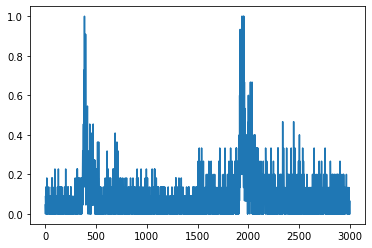

In [12]:
lc0 = xdata[0]
plt.plot(lc0)
print("Delay is {:.2f}".format(ydata[0]))

699

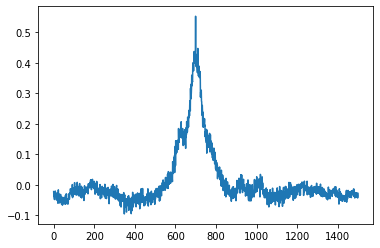

In [13]:
ccf_lc0 = ccf(lc0)
plt.plot(ccf_lc0)
np.argmax(ccf_lc0)

In [14]:
ccfdata = np.apply_along_axis(func1d=ccf, axis=1, arr=xdata)

In [15]:
#np.savez('/content/drive/My Drive/data/ccfdata_6e4.npz',ccfdata)

In [16]:
# ccfdata = np.load('/content/drive/My Drive/data/ccfdata_6e4.npz')
# ccfdata=ccfdata['arr_0']

(59999, 120)

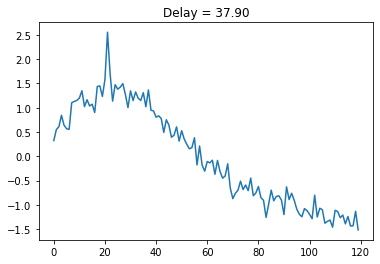

In [73]:
half_ccf = ccfdata.shape[1]//2
window_size = 120 # 120
ccfdata = ccfdata[:,half_ccf-window_size//2:half_ccf+window_size//2]
ccfdata = (ccfdata - np.mean(ccfdata, axis=1)[:,None])/np.std(ccfdata,axis=1)[:,None]
plt.plot(ccfdata[0])
plt.title("Delay = %.2f"%ydata[0])
ccfdata.shape

In [74]:
# shuffling and splitting
Nsamples = ydata.shape[0]
shuffle_ind = np.arange(Nsamples)
np.random.shuffle(shuffle_ind)

ccfdata = ccfdata[shuffle_ind]
xdata = xdata[shuffle_ind]
ydata = ydata[shuffle_ind]

xdata.shape, ccfdata.shape, ydata.shape

((59999, 3000), (59999, 120), (59999,))

In [75]:
test_size= 0.3
Ntrain = np.trunc(Nsamples*(1.-test_size)).astype(int)
print(f'{Ntrain} out of {Nsamples} used for training')
X_train1 = xdata[:Ntrain,:half] #lc1
X_train2 = xdata[:Ntrain,half:] # lc2
X_train3 = ccfdata[:Ntrain,:] # ccf

X_test1 = xdata[Ntrain:,:half]
X_test2 = xdata[Ntrain:,half:]
X_test3 = ccfdata[Ntrain:,:]

y_train = ydata[:Ntrain]
y_test = ydata[Ntrain:]

41999 out of 59999 used for training


In [76]:
X_train1.shape, X_train2.shape, X_train3.shape, y_train.shape, X_test1.shape, X_test2.shape, X_test3.shape

((41999, 1500),
 (41999, 1500),
 (41999, 120),
 (41999,),
 (18000, 1500),
 (18000, 1500),
 (18000, 120))

In [100]:
# Y shape network, two inputs layer 'dense' is common for both branches (same weights)
lc1 = Input(shape=(X_train1[0].shape))
lc2 = Input(shape=(X_train2[0].shape))
ccf0 = Input(shape=(X_train3[0].shape))

# 48, 24
dense_lc1 = Dense(units=64, input_shape=X_train1[0].shape,activation='sigmoid')
dense_lc2 = Dense(units=24, activation='sigmoid')

branch1 = dense_lc1(lc1)
branch1 = dense_lc2(branch1)

branch2  = dense_lc1(lc2)
branch2 = dense_lc2(branch2)

# 32, 8
branch3 = Dense(units=32, input_shape=X_train3[0].shape, activation='sigmoid')(ccf0)
branch3 = Dense(units=16, activation='sigmoid')(branch3)
branch3 = Dense(units=8, activation='sigmoid')(branch3)

merge_layer = Concatenate()([branch1, branch2, branch3])

# 16
mixer_layer = Dense(units=16, activation='sigmoid')(merge_layer)
#mixer_layer = Dense(units=8, activation='sigmoid')(mixer_layer)
predictions = Dense(units=1)(mixer_layer)
model = Model(inputs=[lc1, lc2, ccf0], outputs=predictions)
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 1500)]       0                                            
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 32)           3872        input_42[0][0]                   
______________________________________________________________________________________

In [101]:
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adam', metrics=m)

In [102]:
nepochs = 100
batch_size = 100
h = model.fit([X_train1, X_train2, X_train3],y_train,epochs=nepochs,batch_size=batch_size, validation_data=([X_test1, X_test2, X_test3],y_test), verbose=0)

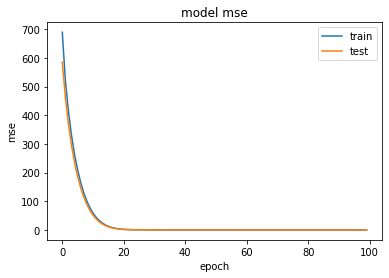

In [103]:
error_evolution(h)

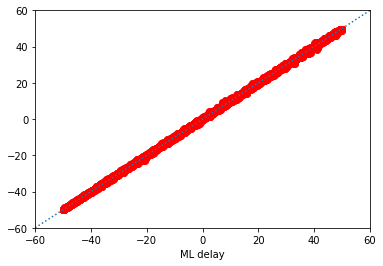

In [104]:
y_pred = model.predict([X_test1, X_test2, X_test3])
accuracy_plot(y_test, y_pred)

(0.028360110243371282, 0.1891266768240909)

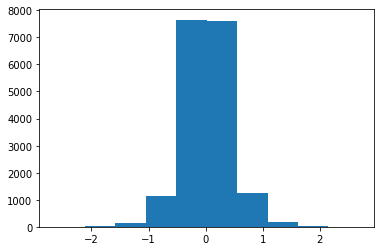

In [105]:
howGoodAmI(y_test, y_pred)